# Aufgabe 8
In dieser Aufgabe geht es darum, Zufallszahlen, die der Planck-Verteilung folgen sollen, (effizient) zu generieren. Zunächst werden einige Dinge berechnet...

In [1]:
import numpy as np
from scipy import optimize
from scipy import integrate
from numpy import random
import matplotlib.pyplot as plt
import timeit

In [2]:
def planck(x):
    return 15/np.pi**4 * x**3/(np.exp(x)-1)


def planckDerivative(x):
    return 15/np.pi**4*x**2 * (3*(np.exp(x)-1)-x*np.exp(x))/(np.exp(x)-1)**2

In [3]:
# Calculating the maximum of the planck distribution
x_max = optimize.brentq(planckDerivative,0.01,10)
y_max = planck(x_max)
print(x_max)
print(y_max)

2.8214393721220787
0.218886470091


In [4]:
# Defining the majorant which is used for the importance sampling
def majorant(x, x_s, y_max):
    if x <= x_s:
        return y_max
    else:
        return 200 * 15/np.pi**4 *x**(-0.1)*np.exp(-x**(0.9))


# We minimize this function to calculate the intersection
def intersectionFindFunction(x):
    return y_max - 200 * 15/np.pi**4 *x**(-0.1)*np.exp(-x**(0.9))


def inverseCDFOfMajorant(x, x_s, y_max):
    if x <= y_max*x_s: 
        # This is very important and results from the inversion of the CDF
        return x/y_max
    else:
        return (-np.log((y_max*x_s-x)/(2000/9*15/np.pi**4) + 
                        np.exp(-x_s**(9/10))))**(10/9)

In [5]:
# Calculating the intersection of the branches of the majorant
x_s = optimize.brentq(intersectionFindFunction, 4, 12)
print(x_s)

5.678208598337557


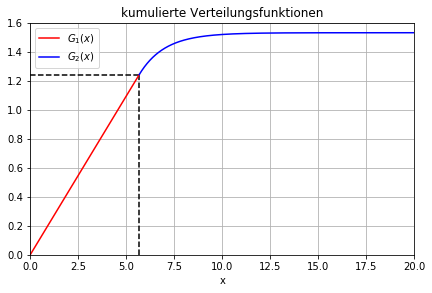

In [6]:
x_g1 = np.linspace(0.001,x_s,1000)
x_g2 = np.linspace(x_s,20,1000)
x_lim1 = [x_s, x_s]
y_lim1 = [0, y_max*x_s]
x_lim2 = [0, x_s]
y_lim2 = [y_max*x_s, y_max*x_s]

plt.plot(x_lim1, y_lim1, 'k--')
plt.plot(x_lim2, y_lim2, 'k--')
plt.plot(x_g1, y_max*x_g1, 'r-', label=r'$G_1(x)$') 
# CDF for 0 < x < x_s
plt.plot(x_g2, y_max*x_s + 
         2000/9*15/np.pi**4*(np.exp(-x_s**(9/10))-np.exp(-x_g2**(9/10))), 
         'b-', label=r'$G_2(x)$')
# CDF for x_s < x 
plt.grid()
plt.legend()
plt.xlabel('x')
plt.tight_layout()
plt.xlim(0,20)
plt.ylim(0,1.6)
plt.title('kumulierte Verteilungsfunktionen')
plt.show()

Der oben stehende Plot zeigt die Verteilungsfunktionen $G_1(x)$ für $x$ zwischen $0$ und $x_s$ und $G_2(x)$ für $x > x_s$.
Es werden gleichverteilte Zahlen zwischen $0$ und dem Grenzwert von $G_2(x)$ gezogen.
Wenn die Zufallszahl zwischen $0$ und $x_s$ liegt, wird mit $G_1(x)^{-1}$ transformiert.
Für Zufallszahlen größer als $x_s$ wird mit $G_2(x)^{-1}$ transformiert.

## Teilaufgaben a) und b)
Hier werden zwei Sample, die planck-verteilt sind, generiert. Dabei wird zum Einen das Rejection Sampling und zum Anderen das Importance Sampling genutzt. Dazu werden die Algorithmen zunächst in Funktionen definiert und in einem Hauptteil dann ein Mal ausgeführt, um die Samples zu generieren.

In [7]:
def RejectionSampling(sampleRejection, x_cut, y_max):
    counter = 0 # this variable counts the amount of rejected proposals
    while(len(sampleRejection) < 1e5): 
        # < and not <= because arrays start at 0 in python
        x = x_cut * random.random() 
        # This generates a random x from 0 to x_cut, x_cut not included
        y = y_max * random.random()
        if y < planck(x):
            sampleRejection.append(x)
        else:
            counter += 1 # we add 1 here because the x we generated is rejected
    return sampleRejection, counter

def ImportanceSampling(sampleImportance, x_cut, y_max, inverseMax):
    counter = 0 
    while(len(sampleImportance) < 1e5):
        x = inverseMax*random.random() # This generates a random x from 0 to 1.53
        y = random.random()
        xStrich = inverseCDFOfMajorant(x, x_s, y_max)
        if y < planck(xStrich)/majorant(xStrich, x_s, y_max):
            sampleImportance.append(xStrich)
        else:
            counter += 1
    return sampleImportance, counter

In [8]:
random.seed = 42
x_cut = 20

sampleRejection = []
sampleRejection, counter1 = RejectionSampling(sampleRejection, x_cut, y_max)

sampleImportance = []
inverseMax = y_max * x_s - 2000/9 * 15/np.pi**4 * (np.exp(-1000**(0.9))-np.exp(-x_s**(0.9)))
# inverseMax is the limit of the cdf of the majorant as x tends to infty.
# It is used in the generation of  x because the majorant cant be a proper pdf.
# This is because it is always greater or equal than a normalized pdf. 
#We hope this is at least somewhat correct...
sampleImportance, counter2 = ImportanceSampling(sampleImportance, 
                                                x_cut, y_max, inverseMax)

## Teilaufgabe c)
Zunächst werden die generierten Samples histogrammiert geplottet und mit der Theorie-PDF verglichen. Es ist eine gute Übereinstimmung ersichtlich.

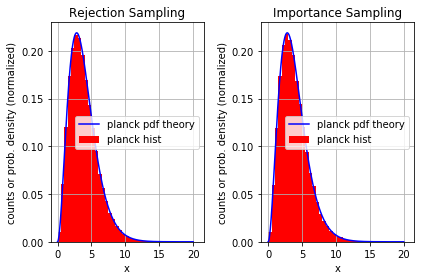

In [9]:
plt.clf()
x_lin = np.linspace(0.001,20,1000) 
# we start at 0.001 (very close to zero and noticeable in the plot)
# because we want to avoid that 
# python is unable to assign truths values elementwise.
plt.subplot(1,2,1)
plt.title('Rejection Sampling')
plt.hist(sampleRejection, bins=np.arange(start=0, stop=21, step=0.5), 
         normed = True,
         histtype='bar', label='planck hist', color='r')
plt.plot(x_lin, planck(x_lin), 'b-', label='planck pdf theory')
plt.grid()
plt.legend()
plt.xlabel('x')
plt.ylabel('counts or prob. density (normalized)')
plt.subplot(1,2,2)
plt.title('Importance Sampling')
plt.hist(sampleImportance, bins=np.arange(start=0, stop=21, step=0.5), 
         normed = True,
         histtype='bar', label='planck hist', color='r')
plt.plot(x_lin, planck(x_lin), 'b-', label='planck pdf theory')
plt.grid()
plt.legend()
plt.xlabel('x')
plt.ylabel('counts or prob. density (normalized)')
plt.tight_layout()
plt.show()

Nun wird noch die Laufzeit mithilfe des timeit-Moduls aus Python geprüft. Dafür wird 20 Mal ein Sample mit beiden Methoden generiert und die kürzeste Zeit ausgegeben, um eine ungefähre untere Grenze für die Laufzeit auszugeben. Eine Mittelwertbildung oder Ähnliches ist nicht sinnvoll, da die Laufzeit auch von Hintergrundprozessen und anderen Anwendungen auf dem ausführenden Computer beeinflusst wird. Danach werden die durchschnittlich zusätzlich erzeugten Zufallszahlen angezeigt, diese werden hier durch Mittelung über 20 Runs erhalten. Dabei interpretieren wir die zusätzlich erzeugten y, die nur zum konkreten Realisieren der Annahmewahrscheinlichkeit generiert werden, nicht als verworfene Zufallszahl, sodass nur die x-Werte gezählt werden, die nicht angenommen werden.
Klar zu erkennen ist, dass das Importance Sampling bei der Planck-Verteilung mit einem Cut von 20 dem Rejection Sampling in beiden Aspekten überlegen ist. Das entspricht den Erwartungen, da beim Rejection Sampling eine hohe Fläche über der niedrigen Verteilung für hohe x liegt, wo natürlich trotzdem Punkte auftauchen, die aber so gut wie nie angenommen werden können. Das wird mit der Majorante besser gemacht.
Anmerkung: Die Anzahl der Runs kann im Code problemlos angepasst werden. Sie kann erhöht werden, falls eine höhere Genauigkeit erwünscht ist oder verringert werden, damit das Programm schneller terminiert.

In [10]:
# Testing the runtime of the two methods through timeit
# Only the minimal runtime is displayed 
#which can be interpreted as the lowest possible time on the operating computer
SETUP_CODE = '''
import numpy as np
from scipy import optimize
from scipy import integrate
from numpy import random
import matplotlib.pyplot as plt
import timeit
from __main__ import RejectionSampling
'''

TEST_CODE = ''' 
sampleRejection = []
sampleRejection = RejectionSampling(sampleRejection, 
x_cut = 20, y_max = 0.218886470091)
'''
      
times = timeit.repeat(setup = SETUP_CODE, stmt = TEST_CODE, 
                      repeat = 1, number = 1)
print('The minimal time elapsed for sampling 1e5 random numbers through rejection sampling in 20 tries is',
      min(times), 'seconds.')

SETUP_CODE = '''
import numpy as np
from scipy import optimize
from scipy import integrate
from numpy import random
import matplotlib.pyplot as plt
import timeit
from __main__ import ImportanceSampling
y_max = 0.218886470091
x_s = 5.678208598337557
inverseMax = y_max * x_s - 2000/9 * 15/np.pi**4 * (np.exp(-1000**(0.9))-np.exp(-x_s**(0.9)))
'''

TEST_CODE = '''
sampleImportance = []
sampleImportance = ImportanceSampling(sampleImportance, 20, 0.218886470091, inverseMax)
'''
      
times = timeit.repeat(setup = SETUP_CODE, stmt = TEST_CODE, 
                      repeat = 1, number = 1)
print('The minimal time elapsed for sampling 1e5 random numbers through importance sampling in 20 tries is',
      min(times), 'seconds.')

The minimal time elapsed for sampling 1e5 random numbers through rejection sampling in 20 tries is 2.899422200153478 seconds.
The minimal time elapsed for sampling 1e5 random numbers through importance sampling in 20 tries is 1.6371285645695437 seconds.


In [11]:
# Estimating the amount of discarded random numbers for the two methods
counterarray = []
for i in range(0,20):
    sampleRejection = []
    _, counter1 = RejectionSampling(sampleRejection, x_cut, y_max)
    counterarray.append(counter1)
counterarray = np.asarray(counterarray)
print('The average amount of discarded random numbers to sample 1e5 numbers through rejection sampling in 20 tries is',
      np.mean(counterarray))

counterarray = []
for i in range(0,20):
    sampleImportance = []
    _, counter2 = ImportanceSampling(sampleImportance, x_cut, y_max, inverseMax)
    counterarray.append(counter2)
counterarray = np.asarray(counterarray)
print('The average amount of discarded random numbers to sample 1e5 numbers through Importance sampling in 20 tries is',
      np.mean(counterarray))

The average amount of discarded random numbers to sample 1e5 numbers through rejection sampling in 20 tries is 338358.2
The average amount of discarded random numbers to sample 1e5 numbers through Importance sampling in 20 tries is 53206.8
